In [1]:
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from mpl_toolkits.basemap import Basemap
import seaborn as sns

Read stored data from the data_preparation notebook (that needs to have run beforehand).

In [2]:
# @formatter:off
# %store -r df_airports
# %store -r airports_dict
# %store -r df_merged
# @formatter:on
G = nx.read_graphml('data/network.xml')
GG = nx.Graph()
for u,v,d in G.edges(data=True):
    w = d['weight']
    if GG.has_edge(u,v):
        GG[u][v]['weight'] += 1
    else:
        GG.add_edge(u,v,weight=1)
# check connectedness
nx.is_connected(G.to_undirected())


False

Calculate the centralities metrics for the network, and set them as node attributes, and for easier plotting,
we include the centralities in an array.

In [3]:
degree_centrality = nx.degree_centrality(GG)
closeness_centrality = nx.closeness_centrality(GG)
betweenness_centrality = nx.betweenness_centrality(GG)
eigenvector_centrality = nx.eigenvector_centrality(GG)

nx.set_node_attributes(GG, closeness_centrality, 'closeness centrality')
nx.set_node_attributes(GG, degree_centrality, 'degree centrality')
nx.set_node_attributes(GG, betweenness_centrality, 'betweenness centrality')
nx.set_node_attributes(GG, eigenvector_centrality, 'eigenvector centrality')


centralityArr = [degree_centrality, closeness_centrality,
                 betweenness_centrality, eigenvector_centrality]
centralityNames = ['degree', 'closeness', 'betweenness', 'eigenvector']


We need to convert the airports long/lat positions into the map projection

c.f. https://matplotlib.org/basemap/users/mapcoords.html

In [4]:
map = Basemap(projection='merc', resolution='c',
              llcrnrlat=20, urcrnrlat=75,
              llcrnrlon=-35, urcrnrlon=55,)

pos = {}
for n in GG.nodes():
    x,y = map(G.nodes[n]['nodeLong'], G.nodes[n]['nodeLat'])
    pos[n] = (x,y)

## Centralities
Plot each previously computed centrality on the world map.
These plots use the `viridis` colormap, c.f. https://matplotlib.org/stable/tutorials/colors/colormaps.html
where purple values are low, blue-greenish in the middle and high value are mapped to yellow.

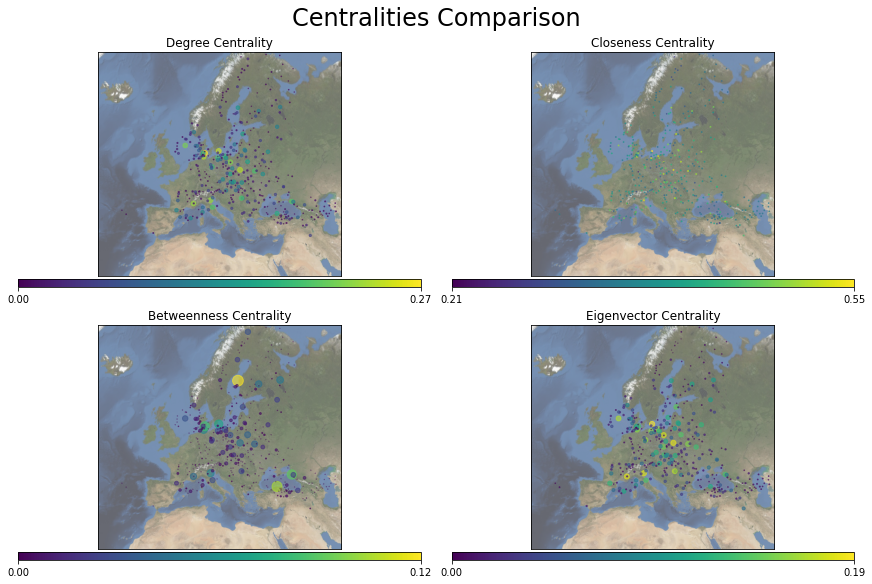

In [5]:
# scale node size based on centrality measure
nodesizes_dict = {
    'degree':100,
    'closeness':2,
    'betweenness':1000,
    'eigenvector':150
}

fig, axes = plt.subplots(2, 2, figsize=(12,8), constrained_layout=True)
for centrality, name, ax in zip(centralityArr, centralityNames, axes.flat):

    # get centrality measure
    CC = np.array(list(nx.get_node_attributes(GG, f'{name} centrality').values()))

    map = Basemap(projection='merc', resolution='c',
                llcrnrlat=25, urcrnrlat=70,
                llcrnrlon=-25, urcrnrlon=55,ax=ax)
    cmap = plt.cm.get_cmap('viridis')
    vmin = min(CC)
    vmax = max(CC)

    # scale nodes. if too small to be drawn would disappear. => show as 1e-1. else would not good with colormap.
    nodesizes = [v * nodesizes_dict[name] if v * nodesizes_dict[name] > 1e-1 else 1e-1 for v in centrality.values()]

    map.bluemarble(alpha=0.6)
    # draw twice due to different alpha values: first one is lines only with very low alpha, second one is nodes only
    nx.draw_networkx(GG, pos=pos, node_size=0, width=0.05, node_color=CC, vmin=vmin, vmax=vmax,
                     cmap=cmap, arrows=False, with_labels=False, edge_color='w', alpha=0.1,
                     node_shape='o', ax=ax)
    nx.draw_networkx(GG, pos=pos, width=0.0, node_color=CC, vmin=vmin, vmax=vmax,
                     cmap=cmap, arrows=False, with_labels=False, edge_color='w', alpha=0.6,
                     node_shape='o', node_size=nodesizes, ax=ax)

    # Create colorbar according to https://stackoverflow.com/a/49572947/14720136
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    # custom ticks https://matplotlib.org/3.3.3/gallery/ticks_and_spines/colorbar_tick_labelling_demo.html
    cbar = plt.colorbar(sm, orientation='horizontal', aspect=50, ticks=[0,1], pad = 0.01, ax=ax)
    cbar.ax.set_xticklabels([f'{vmin:.2f}', f'{vmax:.2f}'])
    ax.set_title(f'{name.capitalize()} Centrality')
plt.suptitle('Centralities Comparison', fontsize=24)
plt.savefig(f'Figures/centrality/geo_Centralities.png', dpi=600)


## Degree Distribution

In [6]:
G_DEGS = [GG.degree()[i] for i in GG.nodes()]
bins = np.logspace(np.log10(min(G_DEGS)), np.log10(max(G_DEGS) + 1), 30)
# take the average value of all degrees => note: in & out degree
AVG_VAL = np.average(G_DEGS)

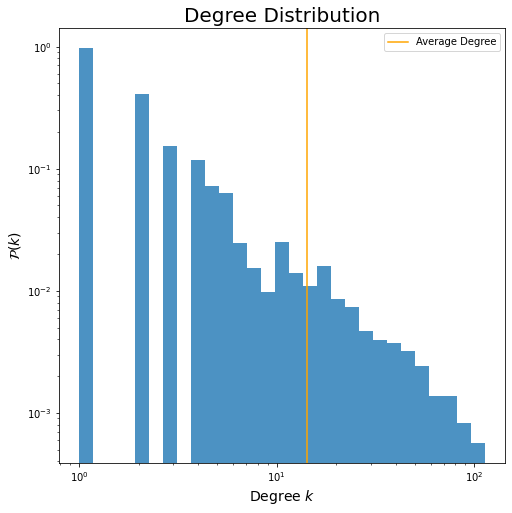

In [7]:
fig = plt.figure(figsize=(8, 8))
plt.hist(G_DEGS, bins=bins, density=True, alpha=0.8)
plt.axvline(x=AVG_VAL, color='r', label='Average Degree', c='orange')
plt.xlabel('Degree $k$', fontsize=14)
plt.ylabel('$\mathcal{P}(k)$', fontsize=14)
plt.title('Degree Distribution', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('Figures/centrality/Degree_distribution.png', dpi=1000)
plt.show()

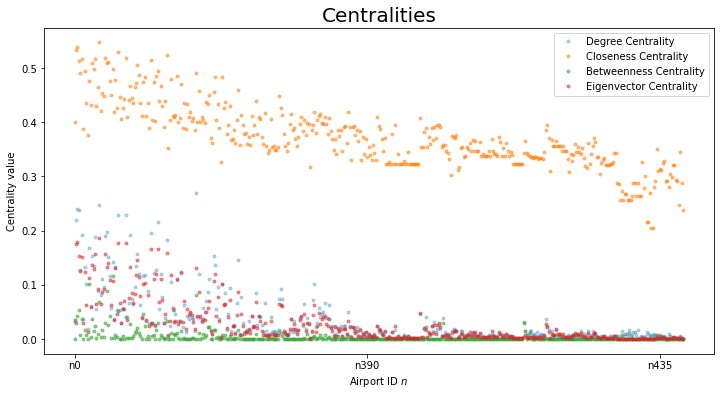

In [8]:
# does not go into the paper
# can see the different distributions here, but since too many nodes can not really make any meaningful statement.
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(degree_centrality.keys(), degree_centrality.values(), linewidth=0, marker='.', label='Degree Centrality',alpha=0.3)
plt.plot(closeness_centrality.keys(), closeness_centrality.values(), linewidth=0, marker='.',
label='Closeness Centrality', alpha=0.5)
plt.plot(betweenness_centrality.keys(), betweenness_centrality.values(), linewidth=0, marker='.',
label='Betweenness Centrality', alpha=0.5)
plt.plot(eigenvector_centrality.keys(), eigenvector_centrality.values(), linewidth=0, marker='.',
label='Eigenvector Centrality', alpha=0.5)
plt.title('Centralities', fontsize=20)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
plt.xlabel('Airport ID $n$')
plt.ylabel('Centrality value')
plt.legend()
plt.savefig('Figures/centrality/Centralities.png', dpi=1000)
plt.show()

build a dataframe with rows as airport ids and columns as the centralities.
This allows us to use seaborn's pair plotting feature.

In [9]:
centralityDict = {}
for k in GG.nodes():
    centralityDict[k] = {}
    centralityDict[k]['betweenness_centrality'] = betweenness_centrality[k]
    centralityDict[k]['closeness_centrality'] = closeness_centrality[k]
    centralityDict[k]['degree_centrality'] = degree_centrality[k]
    centralityDict[k]['eigenvector_centrality'] = eigenvector_centrality[k]
df_centralities = pd.DataFrame.from_dict(centralityDict, orient='index')

<Figure size 1000x1000 with 0 Axes>

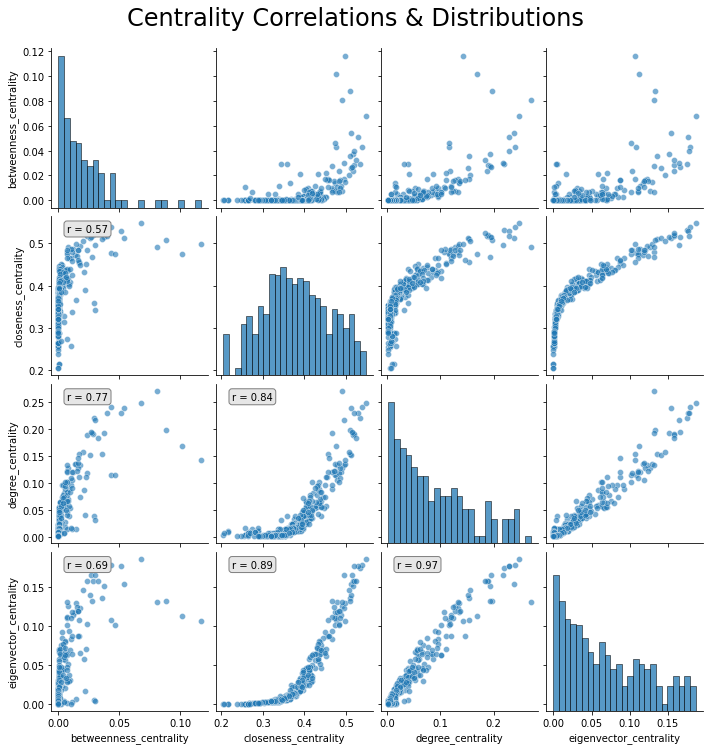

In [10]:
# Plot correlations on top of pairplot: https://stackoverflow.com/a/50835066/14720136
# + added box around correlation https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.html
def plotCorr(x, y, ax=None, **kws):
    p = sp.stats.pearsonr(x,y)[0]
    ax = ax or plt.gca()
    ax.annotate(f'r = {p:.2f}', xy=(.1, .9), xycoords=ax.transAxes,
                bbox=dict(boxstyle="round", fc="0.9", ec="gray")
                )

# diag bars have y axis as log!
fig = plt.figure(dpi=100, figsize=(10,10))
f = sns.pairplot(df_centralities,
                 plot_kws={'alpha':0.6},
                 diag_kws={'bins':25, 'log_scale':(False, True)},
                 diag_kind = 'hist')
f.map_lower(plotCorr)
plt.suptitle('Centrality Correlations & Distributions', y=1.04, fontsize=24)
plt.savefig('Figures/centrality/Centrality_pairplot.png', dpi=600, bbox_inches='tight')

/var/folders/50/2w03ns450yl9ht7z9dkhtr1w0000gn/T/ipykernel_67975/1428030368.py:5: RuntimeWarning: divide by zero encountered in log10
  bins = np.logspace(np.log10(min(betweenness_centrality.values())), np.log10(max(betweenness_centrality.values()) + 1), 30)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start


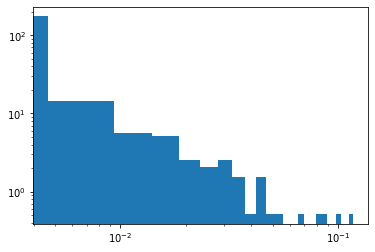

In [11]:
# reference, does not go into the paper.

fig=plt.figure()

bins = np.logspace(np.log10(min(betweenness_centrality.values())), np.log10(max(betweenness_centrality.values()) + 1), 30)
plt.hist(betweenness_centrality.values(), bins=25, density=True)
plt.xscale('log')
plt.yscale('log')
plt.show()